In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import os
import xml.etree.ElementTree as ET
import pickle
import preprocess_library as prepro_lib
from scipy import signal
import pywt
import pandas as pd
from scipy.stats import skew
from scipy.integrate import simpson
import mne
from mne.datasets.sleep_physionet.age import fetch_data




/Users/mariusfauteux/Documents/GitHub/signal-processing-CM2013-ss/EEG-Clasification_V4/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
# Create a look up table for the channels
channels = {
    2: 'EEG(sec)',  # 0-based index for position 3
    3: 'ECG',   # 0-based index for position 4
    4: 'EMG',   # 0-based index for position 5
    5: 'EOG(L)',  # 0-based index for position 6
    6: 'EOG(R)',  # 0-based index for position 7
    7: 'EEG'    # 0-based index for position 8
}

# Create a dict for sampling rate
sampling_rate = {
    2: 125,  # 0-based index for position 3
    3: 125,   # 0-based index for position 4
    4: 125,   # 0-based index for position 5
    5: 125,  # 0-based index for position 6
    6: 125,  # 0-based index for position 7
    7: 125   # 0-based index for position 8
}

# File paths
input_dir = os.path.join(os.getcwd(), 'Input')
output_dir = os.path.join(os.getcwd(), 'Output')
mat_file = os.path.join(input_dir, 'EDF_RawData.mat')

# Create the output directory if it doesn't exist
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

In [3]:
raw_data, xml_data = prepro_lib.load_patient_data(num_patients=10, base_input_dir=input_dir, channels_dict=channels, output_dir=output_dir)

    

Loading raw and XML data from cache files in /Users/mariusfauteux/Documents/GitHub/signal-processing-CM2013-ss/EEG-Clasification_V4/Output...
Successfully loaded data from cache.
Cache contains data for 10 patients.


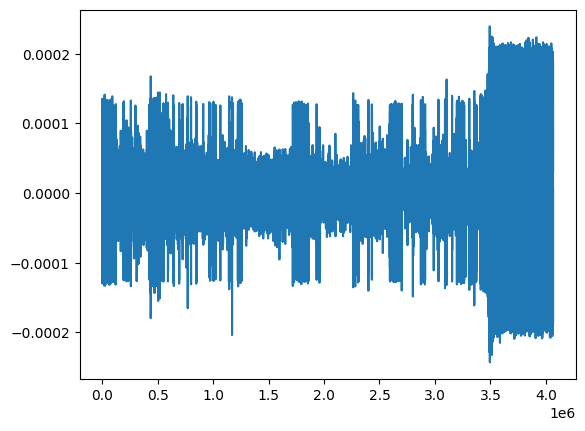

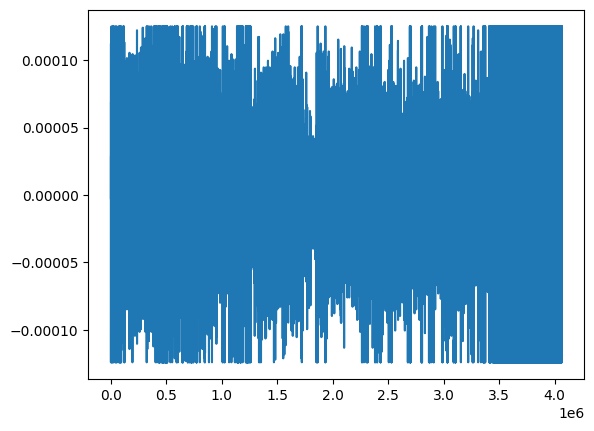

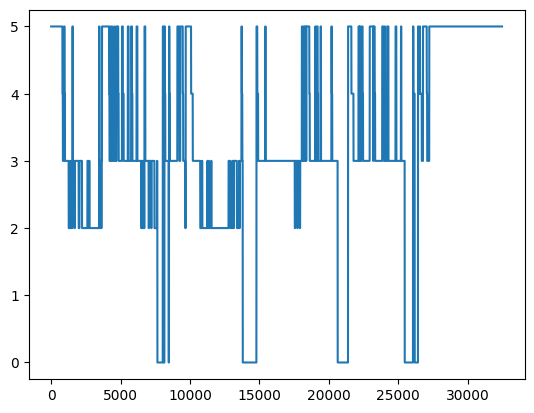

In [4]:
#raw_data = prepro_lib.import_edf_data(input_dir, output_dir, mat_file, sampling_rate)

plt.plot(raw_data[0][channels[5]])
plt.show()

plt.plot(raw_data[0][channels[7]])
plt.show()

plt.plot(xml_data[0]['stages'])
plt.show()



Filtered data file already exists at: /Users/mariusfauteux/Documents/GitHub/signal-processing-CM2013-ss/EEG-Clasification_V4/Output/filtered_data.pkl
Loading existing data instead of reprocessing.


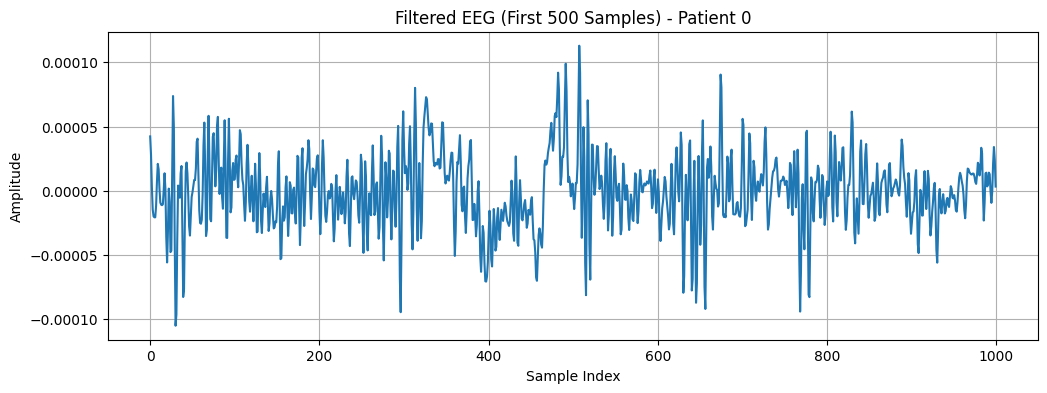

[-1.69789359e-06 -3.04190084e-06 -4.27477526e-06 -4.43728792e-06
 -4.31617565e-06 -6.47804671e-06 -1.09963423e-05 -1.32920687e-05
 -7.64705265e-06  4.69129381e-06]


In [5]:
filtered_data = prepro_lib.filter_data(raw_data, channels, sampling_rate, output_dir, normalize=False)

# Plot the first 500 samples of the filtered EEG channel for patient 0
plt.figure(figsize=(12, 4)) # Optional: Adjust figure size
plt.plot(filtered_data[0]['EEG'][5000:6000])
plt.title("Filtered EEG (First 500 Samples) - Patient 0")
plt.xlabel("Sample Index")
plt.ylabel("Amplitude")
plt.grid(True)
plt.show()

# Display the first few values as well (optional)
print(filtered_data[0]['EEG'][:10])


ICA cleaned data file already exists at: /Users/mariusfauteux/Documents/GitHub/signal-processing-CM2013-ss/EEG-Clasification_V4/Output/ica_cleaned_data.pkl
Loading existing data instead of reprocessing.


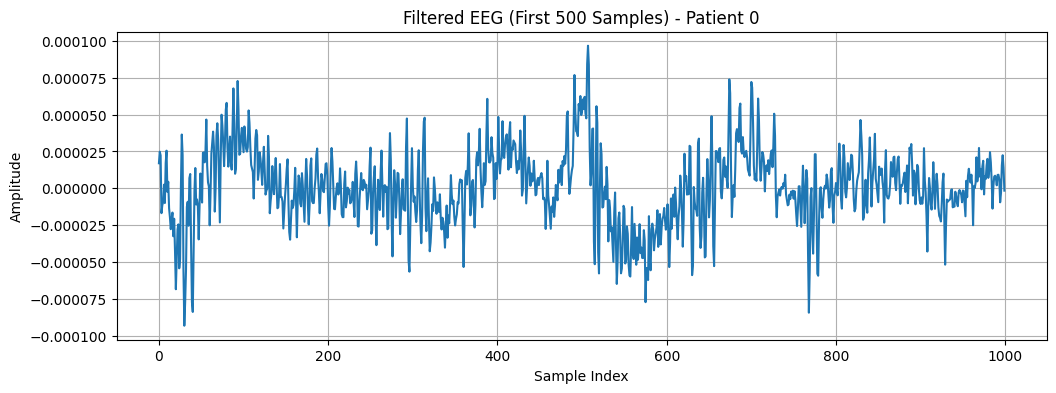

[ 2.75492416e-06  4.70670203e-07 -4.13787520e-07 -1.42435178e-06
 -6.52940487e-06 -4.29607299e-06 -1.40082475e-05 -8.55358850e-06
 -1.00420977e-05 -1.02679012e-05]


In [6]:
ica_cleaned_data = prepro_lib.apply_ica(filtered_data, channels, sampling_rate, output_dir)

# Plot the first 500 samples of the filtered EEG channel for patient 0
plt.figure(figsize=(12, 4)) # Optional: Adjust figure size
plt.plot(ica_cleaned_data[0]['EEG'][5000:6000])
plt.title("Filtered EEG (First 500 Samples) - Patient 0")
plt.xlabel("Sample Index")
plt.ylabel("Amplitude")
plt.grid(True)
plt.show()

# Display the first few values as well (optional)
print(ica_cleaned_data[0]['EEG'][:10])

In [7]:
# Apply adaptive filtering
adaptively_filtered_data = prepro_lib.adaptive_filter(
    input_data=filtered_data, # Or ica_cleaned_data
    channels=channels,
    sampling_rate=sampling_rate,
    output_dir=output_dir,
    lms_order=10, # Optional: Adjust filter order
    lms_mu=0.01   # Optional: Adjust learning rate
)



Adaptively filtered data file already exists at: /Users/mariusfauteux/Documents/GitHub/signal-processing-CM2013-ss/EEG-Clasification_V4/Output/adaptively_filtered_data_M10_mu0.01.pkl
Loading existing data instead of reprocessing.


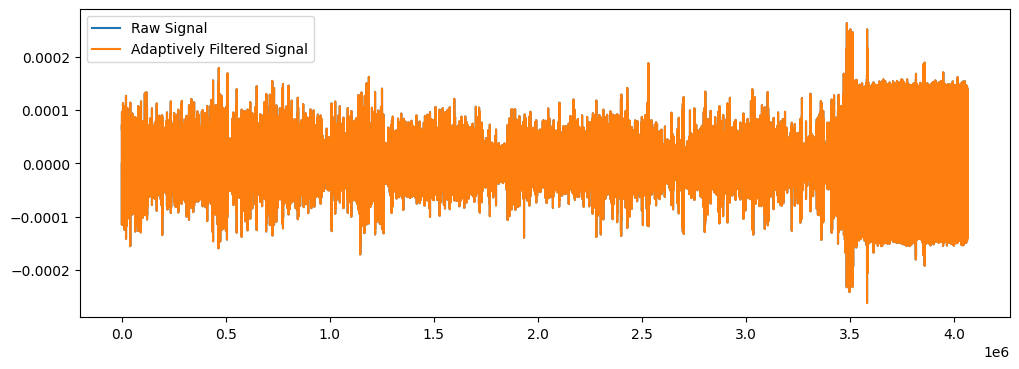

In [8]:
# Overlay the adaptively filtered signal with the raw signal
plt.figure(figsize=(12, 4))
plt.plot(filtered_data[0][channels[7]], label='Raw Signal')
plt.plot(adaptively_filtered_data[0][channels[7]], label='Adaptively Filtered Signal')
plt.legend()
plt.show()


In [9]:
processed_data = prepro_lib.create_epochs(adaptively_filtered_data, channels, sampling_rate, output_dir)
print(f"\nExample epoch shape: {processed_data[1][channels[5]][0]}") # ica_cleaned_data


Processed epochs file already exists at: /Users/mariusfauteux/Documents/GitHub/signal-processing-CM2013-ss/EEG-Clasification_V4/Output/patients_epoch.pkl
Loading existing epochs instead of reprocessing.

Example epoch shape: [1.04568350e-05 8.34859001e-06 6.06510086e-06 ... 1.32058298e-05
 1.27943053e-05 1.15623813e-05]


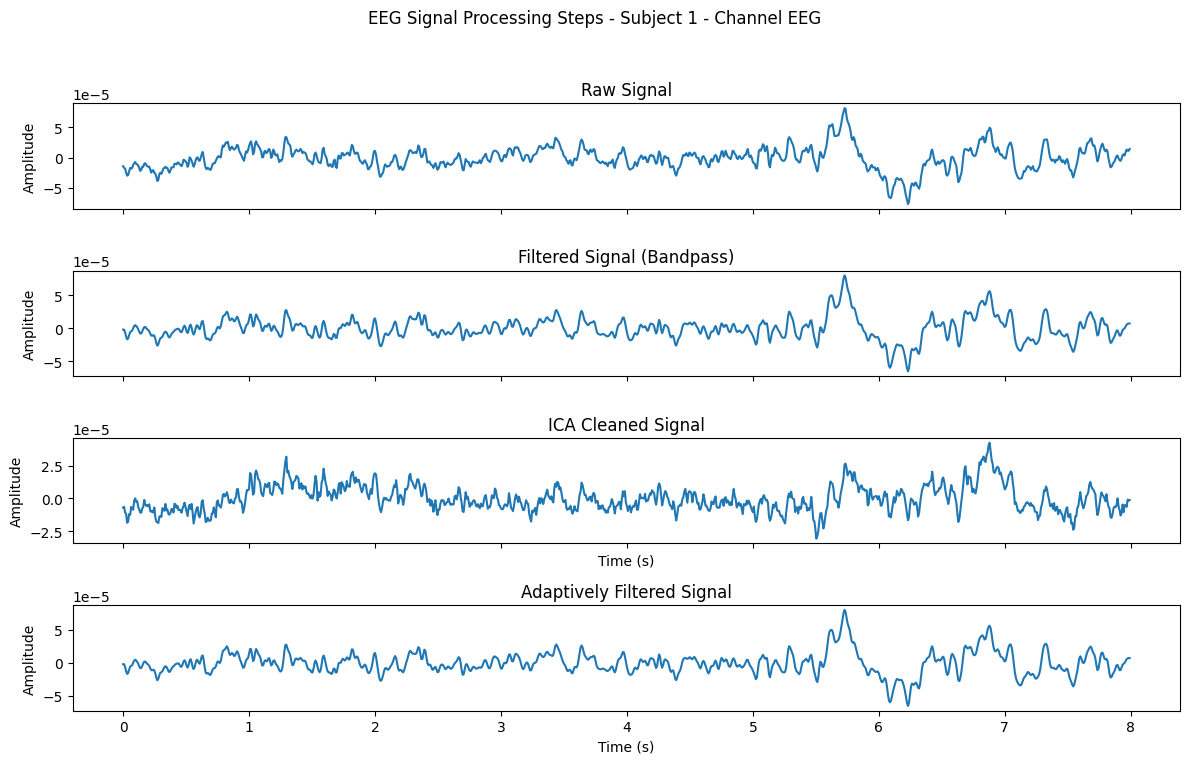

In [10]:
# Select subject index and channel name
subject_index = 0
channel_name = channels[7] # 'EEG'
channel_idx = 7 # Corresponding index for sampling_rate dict

# Get sampling frequency from the sampling_rate dictionary
sfreq = sampling_rate[channel_idx]

# Get data for the selected channel (already numpy arrays)
raw_signal = raw_data[subject_index][channel_name]
filtered_signal = filtered_data[subject_index][channel_name]
ica_cleaned_signal = ica_cleaned_data[subject_index][channel_name]
adaptively_filtered_signal = adaptively_filtered_data[subject_index][channel_name]

# Select 1000 samples from the middle
data_length = len(raw_signal)
mid_point = data_length // 2
start_idx = max(0, mid_point - 500) # Ensure start_idx is not negative
end_idx = min(data_length, start_idx + 5000) # Ensure end_idx does not exceed length

# Adjust start_idx if end_idx hit the boundary first and segment is < 1000
start_idx = max(0, end_idx - 1000)

raw_segment = raw_signal[start_idx:end_idx]
filtered_segment = filtered_signal[start_idx:end_idx]
ica_cleaned_segment = ica_cleaned_signal[start_idx:end_idx]
adaptively_filtered_segment = adaptively_filtered_signal[start_idx:end_idx]
# Create time vector for the segment
# Check if segment is not empty before creating time vector
if len(raw_segment) > 0:
    time_segment = np.arange(len(raw_segment)) / sfreq

    # Plotting
    fig, axes = plt.subplots(4, 1, figsize=(12, 8), sharex=True)
    fig.suptitle(f'EEG Signal Processing Steps - Subject {subject_index + 1} - Channel {channel_name}')

    axes[0].plot(time_segment, raw_segment)
    axes[0].set_title('Raw Signal')
    axes[0].set_ylabel('Amplitude') # Units might vary, remove uV assumption

    axes[1].plot(time_segment, filtered_segment)
    axes[1].set_title('Filtered Signal (Bandpass)')
    axes[1].set_ylabel('Amplitude')

    axes[2].plot(time_segment, ica_cleaned_segment)
    axes[2].set_title('ICA Cleaned Signal')
    axes[2].set_xlabel('Time (s)')
    axes[2].set_ylabel('Amplitude')

    axes[3].plot(time_segment, adaptively_filtered_segment)
    axes[3].set_title('Adaptively Filtered Signal')
    axes[3].set_xlabel('Time (s)')
    axes[3].set_ylabel('Amplitude')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent title overlap
    plt.show()
else:
    print(f"Warning: Selected segment for channel '{channel_name}' (Subject {subject_index + 1}) is empty.")


In [11]:
wavelet_data = prepro_lib.wavelet_decomposition(processed_data, channels, sampling_rate, output_dir)

if wavelet_data and channels[7] in wavelet_data[0]:
        print(f"Shape of Delta band epochs for {channels[7]} (Subject 1): {wavelet_data[0][channels[7]]['Delta'].shape}")

Loading wavelet features from /Users/mariusfauteux/Documents/GitHub/signal-processing-CM2013-ss/EEG-Clasification_V4/Output/wavelet_features.pkl...
Shape of Delta band epochs for EEG (Subject 1): (1084, 3750)


In [12]:
prepro_lib.plot_band_power_with_stages(
    wavelet_data=wavelet_data,
    xml_data=xml_data,
    channels=channels,
    sampling_rate=sampling_rate,
    output_dir=output_dir,
    subject_index=3,         # Plot the first subject
    eeg_channel_name='EEG'   # Use the 'EEG' channel (or 'EEG(sec)')
)

\nGenerating band power and hypnogram plot for Subject 4, Channel EEG...
  Calculating power for 875 epochs...
  Plot saved to: /Users/mariusfauteux/Documents/GitHub/signal-processing-CM2013-ss/EEG-Clasification_V4/Output/Figures/BandPower_Hypnograms/subject_4_EEG_bandpower_hypno.png


In [13]:
spindle_results = prepro_lib.spindle_detection(wavelet_data, channels, sampling_rate, output_dir)

Loading spindle results from /Users/mariusfauteux/Documents/GitHub/signal-processing-CM2013-ss/EEG-Clasification_V4/Output/spindle_results.pkl...


In [14]:
features_dataframe = prepro_lib.extract_features(wavelet_data, spindle_results, channels, sampling_rate, output_dir)
# Display first few rows of the features dataframe
print("\nFeature DataFrame Head:")
print(features_dataframe.head())

Loading features from /Users/mariusfauteux/Documents/GitHub/signal-processing-CM2013-ss/EEG-Clasification_V4/Output/features_dataset.csv...

Feature DataFrame Head:
           Mean        Median      Variance  Skewness  MeanAbsVal  \
0  5.059275e-08  3.111695e-07  3.411777e-10  0.265893    0.000013   
1 -1.786384e-08 -1.552888e-07  3.815478e-10  0.268249    0.000014   
2  4.988258e-08 -2.139370e-08  1.784024e-10  0.049970    0.000010   
3 -1.941461e-08 -1.001482e-07  4.204580e-10 -0.253939    0.000015   
4 -1.260013e-08 -1.068043e-07  1.922488e-10 -0.162207    0.000010   

   Delta_AbsPwr  Theta_AbsPwr  Alpha_AbsPwr  Sigma_AbsPwr   Beta_AbsPwr  ...  \
0  1.489590e-10  1.759092e-11  2.664841e-11  2.908118e-11  1.263425e-10  ...   
1  1.351103e-10  2.398276e-11  4.426870e-11  5.414865e-11  1.650408e-10  ...   
2  4.056661e-11  1.539807e-11  1.867171e-11  2.967729e-11  9.371653e-11  ...   
3  1.961345e-10  3.123500e-11  4.068505e-11  4.716384e-11  1.438728e-10  ...   
4  6.554877e-11  1.4

In [15]:
print("\n--- Starting Sleep Stage Classification --- ")
try:
    model, label_encoder, eval_results = prepro_lib.classify_sleep_stages(
        features_dataframe=features_dataframe,
        xml_data=xml_data,
        output_dir=output_dir
    )
    print("\n--- Classification Finished --- ")
    # You can access the trained model, encoder, and results here if needed
    # print(f"Final Accuracy: {eval_results['accuracy']:.4f}")
except Exception as e:
    print(f"Error during sleep stage classification: {e}")


--- Starting Sleep Stage Classification --- 
\n--- Starting Sleep Stage Classification ---
Preparing target labels from XML data...
Generated 10293 epoch labels.
Stage distribution in labels:
 Stage
N2      3808
Wake    3474
N3      1471
REM     1118
N1       275
N4       147
Name: count, dtype: int64
Merging features with labels...
Filtering features for 'EEG_Avg' channel.
Merged data shape: (10293, 48)
Stage distribution after merge:
 Stage
N2      3808
Wake    3474
N3      1471
REM     1118
N1       275
N4       147
Name: count, dtype: int64
Preparing data for XGBoost...
Encoded labels: {'N1': 0, 'N2': 1, 'N3': 2, 'N4': 3, 'REM': 4, 'Wake': 5}
Label encoder saved to /Users/mariusfauteux/Documents/GitHub/signal-processing-CM2013-ss/EEG-Clasification_V4/Output/classification/label_encoder.joblib
Splitting data into training (70%) and validation (30%)...
Train set shape: X=(7205, 44), y=(7205,)
Test set shape: X=(3088, 44), y=(3088,)
Training XGBoost classifier...


/Users/mariusfauteux/Documents/GitHub/signal-processing-CM2013-ss/EEG-Clasification_V4/.venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [13:04:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Training complete.
Trained XGBoost model saved to /Users/mariusfauteux/Documents/GitHub/signal-processing-CM2013-ss/EEG-Clasification_V4/Output/classification/xgboost_model.joblib
\n--- Evaluating Model on Validation Set ---
Validation Accuracy: 0.8005
\nClassification Report:
              precision    recall  f1-score      support
N1             0.200000  0.024096  0.043011    83.000000
N2             0.762175  0.821522  0.790737  1143.000000
N3             0.751101  0.773243  0.762011   441.000000
N4             0.773585  0.931818  0.845361    44.000000
REM            0.779851  0.623881  0.693201   335.000000
Wake           0.877684  0.902111  0.889730  1042.000000
accuracy       0.800518  0.800518  0.800518     0.800518
macro avg      0.690733  0.679445  0.670675  3088.000000
weighted avg   0.786540  0.800518  0.790138  3088.000000
\nConfusion Matrix:
      N1   N2   N3  N4  REM  Wake
N1     2   24    0   0    8    49
N2     2  939   98   2   39    63
N3     0   87  341  10    0   

In [16]:
prepro_lib.generate_final_visualizations(
        features_dataframe=features_dataframe,
        xml_data=xml_data,
        evaluation_results=eval_results,
        trained_model=model,
        label_encoder=label_encoder,
        output_dir=output_dir
    )

TypeError: generate_final_visualizations() got an unexpected keyword argument 'trained_model'

In [17]:
print("\\n--- Starting Sleep Stage Classification (Neural Network) --- ")
try:
    # Use the new NN classification function
    nn_model, nn_label_encoder, nn_scaler, nn_eval_results = prepro_lib.classify_sleep_stages_nn(
        features_dataframe=features_dataframe,
        xml_data=xml_data,
        output_dir=output_dir
    )
    print("\\n--- NN Classification Finished --- ")

    # You might want to adapt the final visualization function if you use NN
    # or create a separate one, as it currently expects an XGBoost model object
    # for feature importance. For now, we can skip calling it or modify it.
    # Example:
    if nn_model:
        print("Skipping final visualizations for NN model for now.")
        # Or call a modified/new visualization function:
        prepro_lib.generate_final_visualizations_nn(
            features_dataframe=features_dataframe,
            xml_data=xml_data,
            label_encoder=nn_label_encoder,
            evaluation_results=nn_eval_results,
            output_dir=output_dir
        )

except Exception as e:
    print(f"Error during NN sleep stage classification: {e}")


\n--- Starting Sleep Stage Classification (Neural Network) --- 
\n--- Starting Sleep Stage Classification (Neural Network) ---
Preparing target labels from XML data...
Generated 10293 epoch labels.
Merging features with labels...
Merged data shape: (10293, 48)
Preparing data for Neural Network (Scaling, Encoding)...
Features scaled using StandardScaler. Shape: (10293, 44)
Feature scaler saved to /Users/mariusfauteux/Documents/GitHub/signal-processing-CM2013-ss/EEG-Clasification_V4/Output/classification_nn/feature_scaler.joblib
Encoded labels: {'N1': 0, 'N2': 1, 'N3': 2, 'N4': 3, 'REM': 4, 'Wake': 5}
Labels converted to one-hot encoding. Shape: (10293, 6)
Label encoder saved to /Users/mariusfauteux/Documents/GitHub/signal-processing-CM2013-ss/EEG-Clasification_V4/Output/classification_nn/label_encoder.joblib
Splitting data into training (70%) and validation (30%)...
Train set shape: X=(7205, 44), y=(7205, 6)
Validation set shape: X=(3088, 44), y=(3088, 6)
Defining Keras Sequential model

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         5,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,406 (56.27 KB)

 Trainable params: 14,406 (56.27 KB)

 Non-trainable params: 0 (0.00 B)

Compiling model...
Training Neural Network model...
Epoch 1/100

Epoch 1: val_loss improved from inf to 0.83999, saving model to /Users/mariusfauteux/Documents/GitHub/signal-processing-CM2013-ss/EEG-Clasification_V4/Output/classification_nn/best_nn_model.keras
113/113 - 1s - 7ms/step - accuracy: 0.6197 - loss: 1.0856 - val_accuracy: 0.6933 - val_loss: 0.8400
Epoch 2/100

Epoch 2: val_loss improved from 0.83999 to 0.76034, saving model to /Users/mariusfauteux/Documents/GitHub/signal-processing-CM2013-ss/EEG-Clasification_V4/Output/classification_nn/best_nn_model.keras
113/113 - 0s - 1ms/step - accuracy: 0.6924 - loss: 0.8569 - val_accuracy: 0.7173 - val_loss: 0.7603
Epoch 3/100

Epoch 3: val_loss improved from 0.76034 to 0.71777, saving model to /Users/mariusfauteux/Documents/GitHub/signal-processing-CM2013-ss/EEG-Clasification_V4/Output/classification_nn/best_nn_model.keras
113/113 - 0s - 1ms/step - accuracy: 0.7142 - loss: 0.7905 - val_accuracy: 0.7358 - val_loss: 0.7178
Epoch 4/100



/Users/mariusfauteux/Documents/GitHub/signal-processing-CM2013-ss/EEG-Clasification_V4/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/mariusfauteux/Documents/GitHub/signal-processing-CM2013-ss/EEG-Clasification_V4/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/mariusfauteux/Documents/GitHub/signal-processing-CM2013-ss/EEG-Clasification_V4/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-d

  Data prepared for plotting (shape: (10293, 48)). Stage order: ['Wake', 'N1', 'N2', 'N3', 'REM']
  Generating Band Power Distribution plot...
    Saved plot: /Users/mariusfauteux/Documents/GitHub/signal-processing-CM2013-ss/EEG-Clasification_V4/Output/Figures_NN/BandPowerDistribution/band_power_distribution_by_stage_nn.png
  Skipping Feature Importance plot (not directly available for this Keras model).
  Generating Confusion Matrix heatmap...
    Saved plot: /Users/mariusfauteux/Documents/GitHub/signal-processing-CM2013-ss/EEG-Clasification_V4/Output/Figures_NN/ConfusionMatrix/confusion_matrix_heatmap_nn.png
  Generating Spindle Density Distribution plot...
    Saved plot: /Users/mariusfauteux/Documents/GitHub/signal-processing-CM2013-ss/EEG-Clasification_V4/Output/Figures_NN/SpindleAnalysis/spindle_density_distribution_by_stage_nn.png
--- Finished Generating Final Visualizations (Neural Network) ---
